# S.VI.C: ORB-SLAM3

This notebook plots and analyzes the results shown in Figure 7g -- 7n of Section VI.C: "ORB-SLAM3."

TODO: Instructions here

Results are already provided in `xxxxx`

To regenerate the results:


    xxxxxxxxx
    xxxxxxxxx


In [1]:
# Import Packages

import os
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.patheffects as pe
import numpy as np
import time
from math import *
import copy
import statistics
from pyquaternion import Quaternion
from pathlib import Path
from mpl_toolkits.mplot3d import Axes3D
import csv
import seaborn as sns

In [2]:
# Define Style for Plotting

# Use the fivethirtyeight style
plt.style.use('fivethirtyeight')

# Define a palette
colors = sns.color_palette("deep", 5)

## Profiling Execution Times

We first measure the execution time of each task.

In [3]:
# Functions for plotting

# paths to read
paths = [] 
prefix = "execution_time_data/"
# prefix = "../data/orb_execution_times/histo_data/MH03/experiment_1/"
paths.append('us_imu_exe_times_file')
paths.append('us_left_camera_exe_times_file')
paths.append('ms_tracking_exe_times_file')
paths.append('ms_ba_exe_times_file')

# units
units = []
units.append('us')
units.append('us')
units.append('ms')
units.append('ms')

def plot_execution_times(i) :
    
    fig, ax = plt.subplots(figsize=(4.2, 3))
    data = []
    # read data
    with open(prefix + paths[i] + '.txt', 'r') as file:
        for line in file:
            content = line.split(',')
            data.append (float(content[1]))

    # Create histogram
    ax.hist(data, bins=30, density=True, alpha=0.8, edgecolor='black', linewidth=1.5, color=colors[i])
    ax.set_yscale('log')
    ax.set_xlabel('Execution Time (' + units[i] + ')', )
    ax.set_ylabel('Frequency')

    # Display the plot
    plt.tight_layout()

    # Save the figure
    fig.savefig(paths[i] + '.eps', format="eps")
    fig.savefig(paths[i] + '.png', format="png")
    fig.show()

    return np.max(data)




### Figure 7j

Plots the execution times of the IMU task and prints the worst-observed execution time $C_i$

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Maximum observed execution time of IMU task: 0.015184 ms


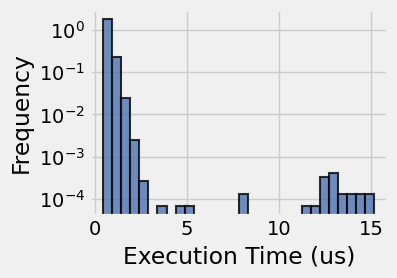

In [4]:
max_imu = plot_execution_times(0)
print(f"Maximum observed execution time of IMU task: {max_imu/1000} ms")

### Figure 7k

Plots the execution times of the Camera workload

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


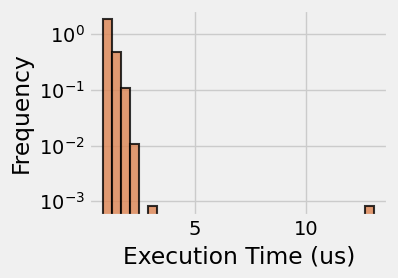

In [5]:
max_cam = plot_execution_times(1)

### Figure 7l

Plots the execution times of the Tracking workload and prints the worst-observed execution time $C_i$ of the combined Camera + Tracking task.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Maximum observed execution time of Camera + Tracking task: 31.315053 ms


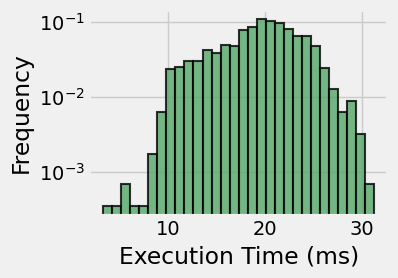

In [6]:
max_track = plot_execution_times(2)
max_cam_track = max_cam/1000+max_track
print(f"Maximum observed execution time of Camera + Tracking task: {max_cam_track} ms")

### Figure 7m

Plots the execution times of the Mapping task and prints the worst-observed execution time $C_i$

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Maximum observed execution time of Mapping task: 270.126 ms


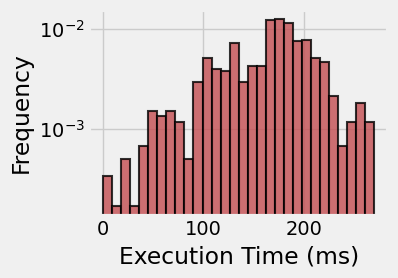

In [16]:
#TODO: This plot is wrong
max_map = plot_execution_times(3)
print(f"Maximum observed execution time of Mapping task: {max_map} ms")

## Assigning Elasticity Values

We use the 

In [8]:
def fit_weight(periods, errs, num=0) :
    R = 1 / (periods / 1000)
    R_max = R[0]
    X = (R_max - R) ** 2
    Y = errs * 10000

    if num == 0 :
        num = X.size

    slope, intercept = np.polyfit(X[0:num], Y[0:num], 1)
    #print(f'y = {slope}x + {intercept}')


    # To visualize
    plt.figure(figsize=(4.6, 2.5))
    plt.scatter(X, Y, color='blue')
    plt.plot(X, slope * X + intercept, color='red', label='Best Fit')
    plt.xlabel(r'$(R^{max} - R)^2$') 
    plt.ylabel('Error')
    plt.tight_layout()
    plt.legend()
    plt.show()

    return slope

def compute_elasticity(c, w) :
    e = c ** 2 / w
    print(f'E: {e}')


### Figure 7g

Plots

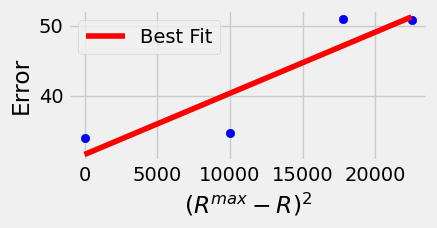

E: 0.26316227276067167


In [30]:
periods = np.arange(5,21,5)
errs = np.array([0.003395034,0.003464164,0.00510176,0.005079174])
w_imu = fit_weight(periods,errs)
compute_elasticity(max_imu/1000, w_imu)


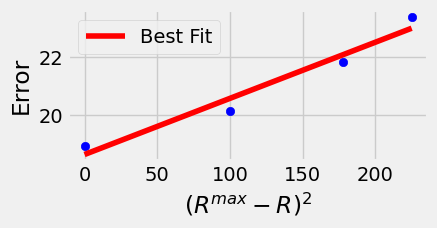

E: 461618.62387549813


In [19]:
#TODO: Clean up
periods = np.arange(50,201,50)
errs = np.array([0.00189339,0.002014436,0.002182768,0.002338362])
w_map = fit_weight(periods,errs)

w_map = 0.15807
# max_map = 285

compute_elasticity(max_map, w_map)

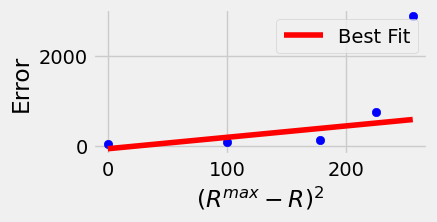

E: 411.4668146173575


In [20]:
periods = np.arange(50,251,50)
errs = np.array([0.003729014,0.008534594,0.01239144,0.074729036,0.28894411])
w_cam = fit_weight(periods,errs, 4) - w_map
compute_elasticity(max_cam_track, w_cam)

In [ ]:
# Functions to Calculate Errors

def save_to_csv(data_list, path_to_save):
    with open(path_to_save, 'w') as csv_file:
        wr = csv.writer(csv_file, quoting=csv.QUOTE_ALL)
        for data in data_list:
            wr.writerow([data])


def relative_translation(p1, p2):
    return [p1[0] - p2[0], p1[1] - p2[1], p1[2] - p2[2]]


def rotation_error(r1, r2):
    diff_r = Quaternion(r1.elements - r2.elements)
    return diff_r.degrees

def translation_error(p1, p2):
    return sqrt(pow(p1[0] - p2[0],2) + pow(p1[1] - p2[1],2) + pow(p1[2] - p2[2],2))

def traj_translation_error(trj1, gt_traj):
    gt_index = 0
    errors = []
    for p in trj1:
        while gt_index < len(gt_traj) and p.timestamp > gt_traj[gt_index].timestamp:
            gt_index = gt_index + 1
        
        if gt_index < len(gt_traj):
            # print('P timestamp: ', p.timestamp, '  GT timestamp: ', gt_traj[gt_index].timestamp)
            # print('Time diff : ', p.timestamp - gt_traj[gt_index].timestamp)
            errors.append(translation_error(p.position, gt_traj[gt_index].position))

    return errors

def traj_relative_translation_error(trj1, gt_traj):
    gt_index = 0
    gt_last_index = 0


    timestamps = []
    errors = []

    last_p = None

    for p in trj1:
        while gt_index < len(gt_traj) and p.timestamp >= gt_traj[gt_index].timestamp:
            gt_index = gt_index + 1
        
        if gt_index < len(gt_traj):
            # print('P timestamp: ', p.timestamp, '  GT timestamp: ', gt_traj[gt_index].timestamp)
            # print('Time diff : ', p.timestamp - gt_traj[gt_index].timestamp)
            if last_p != None:
                relative_trans = relative_translation(p.position,last_p.position)
                relative_trans_gt = relative_translation(gt_traj[gt_index].position, gt_traj[gt_last_index].position)

                timestamps.append(p.timestamp)
                errors.append(translation_error(relative_trans, relative_trans_gt))

            last_p = p
            gt_last_index = gt_index

    return timestamps, errors

def traj_relative_orientation_error(trj1, gt_traj):
    gt_index = 0
    gt_last_index = 0
    errors = []

    last_p = None

    for p in trj1:
        while gt_index < len(gt_traj) and p.timestamp >= gt_traj[gt_index].timestamp:
            gt_index = gt_index + 1
        
        if gt_index < len(gt_traj):
            # print('P timestamp: ', p.timestamp, '  GT timestamp: ', gt_traj[gt_index].timestamp)
            # print('Time diff : ', p.timestamp - gt_traj[gt_index].timestamp)
            if last_p != None:
                # relative_orient = rotation_error(p.orientation,last_p.orientation)
                # relative_orient_gt = rotation_error(gt_traj[gt_index].orientation, gt_traj[gt_last_index].orientation)

                e = rotation_error(p.orientation, gt_traj[gt_index].orientation)

                # print("relatvie orientation : ", e)
                # print("relatvie orientation : ", relative_orient_gt)
                # errors.append(abs(relative_orient - relative_orient_gt))

            last_p = p
            gt_last_index = gt_index

    return errors

def translation(p, t):
    return np.array([p[0]-t[0], p[1]-t[1], p[2]-t[2]])

def distance(p1, p2):
    return sqrt(pow(p1[0] - p2[0], 2) + pow(p1[1] - p2[1], 2))

def error_log(errors):
    import statistics
    # print("    Means        Max        min")
    print('Mean : ', statistics.mean(errors), '    std dev  :  ',  statistics.stdev(errors), '    Max  :  ',  max(errors), '    Min  :  ',  min(errors))


class loc_point:
    def __init__(self):
        self.timestamp = 0
        self.position = None
        self.orientation = None

In [ ]:
# Load Ground Truth

gt_path = 'groudtruth/mh01.csv'

offset_flag = True
offset_p = [] #np.array()
offset_r = Quaternion()
offset_point = None
conj_offset_r = Quaternion()
ground_truth_traj = []

start_time = 0

gtxs = []
gtys = []
gtzs = []

with open(gt_path) as f:
    lines = f.readlines()
    for line in lines:

        # This is the first line
        if line.split(',')[0] == '#timestamp':
            continue

        content = [float(x) for x in line.split(',')]

        new_p = loc_point()

        new_p.timestamp = content[0] / (1.0 * 10e8)
        if start_time == 0:
            start_time = content[0] / (1.0 * 10e8)

        new_p.position = np.array([content[1], content[2], content[3]])
        new_p.orientation = Quaternion(content[4], content[5], content[6], content[7])

        if offset_flag:
            offset_point = copy.copy(new_p)
            conj_offset_r = offset_point.orientation.conjugate
            offset_flag = False
        
        #### Eliminate the initial offset
        new_p.position = translation(new_p.position, offset_point.position)
        new_p.position = conj_offset_r.rotate(new_p.position)

        new_p.orientation = Quaternion(new_p.orientation.elements - offset_point.orientation.elements)

        ### coordination transform
        new_p.position = np.array([new_p.position[1], -new_p.position[0], new_p.position[2]])

        ground_truth_traj.append(new_p)

        gtxs.append(new_p.position[0])
        gtys.append(new_p.position[1])
        gtzs.append(new_p.position[2])

In [ ]:
# Load Experimental Results

#Baseline

baseline_txt_name = "rte_trace_data/Baseline_FrameTrajectory_TUM_Format.txt"
baseline_xs = []
baseline_ys = []
baseline_zs = []
baseline_traj = []
baseline_timestamps = []

with open(baseline_txt_name) as f:
    lines = f.readlines()
    for line in lines:
        content = [float(x) for x in line.split()]

        new_p = loc_point()
        new_p.timestamp = content[0]
        baseline_timestamps.append(content[0])

        new_p.position = np.array([content[1], content[2], content[3]])
        new_p.orientation = Quaternion(content[4], content[5], content[6], content[7])

        baseline_traj.append(new_p)

        baseline_xs.append(new_p.position[0])
        baseline_ys.append(new_p.position[1])
        baseline_zs.append(new_p.position[2])

#IROS
        
iros_txt_name = "rte_trace_data/IROS_FrameTrajectory_TUM_Format.txt"
iros_xs = []
iros_ys = []
iros_zs = []
iros_traj = []
iros_timestamps = []

with open(iros_txt_name) as f:
    lines = f.readlines()
    for line in lines:
        content = [float(x) for x in line.split()]

        new_p = loc_point()
        new_p.timestamp = content[0]
        iros_timestamps.append(content[0])

        new_p.position = np.array([content[1], content[2], content[3]])
        new_p.orientation = Quaternion(content[4], content[5], content[6], content[7])

        iros_traj.append(new_p)

        iros_xs.append(new_p.position[0])
        iros_ys.append(new_p.position[1])
        iros_zs.append(new_p.position[2])


#Elastic Model

elastic_txt_name = "rte_trace_data/Elastic_FrameTrajectory_TUM_Format.txt"
elastic_xs = []
elastic_ys = []
elastic_zs = []
elastic_traj = []
elastic_timestamps = []


with open(elastic_txt_name) as f:
    lines = f.readlines()
    for line in lines:
        content = [float(x) for x in line.split()]

        new_p = loc_point()
        new_p.timestamp = content[0]
        elastic_timestamps.append(content[0])


        new_p.position = np.array([content[1], content[2], content[3]])
        new_p.orientation = Quaternion(content[4], content[5], content[6], content[7])

        elastic_traj.append(new_p)

        elastic_xs.append(new_p.position[0])
        elastic_ys.append(new_p.position[1])
        elastic_zs.append(new_p.position[2])


#Tuned Elastic Model

tuned_elastic_txt_name = "rte_trace_data/Tuned_Elastic_FrameTrajectory_TUM_Format.txt"
tuned_elastic_xs = []
tuned_elastic_ys = []
tuned_elastic_zs = []
tuned_elastic_traj = []
tuned_elastic_timestamps = []

with open(tuned_elastic_txt_name) as f:
    lines = f.readlines()
    for line in lines:
        content = [float(x) for x in line.split()]

        new_p = loc_point()
        new_p.timestamp = content[0]
        tuned_elastic_timestamps.append(content[0])

        new_p.position = np.array([content[1], content[2], content[3]])
        new_p.orientation = Quaternion(content[4], content[5], content[6], content[7])

        tuned_elastic_traj.append(new_p)

        tuned_elastic_xs.append(new_p.position[0])
        tuned_elastic_ys.append(new_p.position[1])
        tuned_elastic_zs.append(new_p.position[2])

In [ ]:
# Calculate RPE

#Downsample for better visualization

baseline_traj = baseline_traj[::10]
iros_traj = iros_traj[::10]
elastic_traj = elastic_traj[::10]
tuned_elastic_traj = tuned_elastic_traj[::10]

baseline_timestamps, baseline_rpe_error = traj_relative_translation_error(baseline_traj, ground_truth_traj)
iros_timestamps, iros_rpe_error = traj_relative_translation_error(iros_traj, ground_truth_traj)
elastic_timestamps, elastic_rpe_error = traj_relative_translation_error(elastic_traj, ground_truth_traj)
tuned_elastic_timestamps, tuned_elastic_rpe_error = traj_relative_translation_error(tuned_elastic_traj, ground_truth_traj)




baseline_timestamps = [x - start_time for x in baseline_timestamps]
iros_timestamps = [x - start_time for x in iros_timestamps]
elastic_timestamps = [x - start_time for x in elastic_timestamps]
tuned_elastic_timestamps = [x - start_time for x in tuned_elastic_timestamps]

# fig, ax = plt.subplots()
plt.style.use('fivethirtyeight')
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
fig, ax = plt.subplots(figsize=(9, 4.5))

# ax = p3.Axes3D(fig)
# plt.subplots_adjust(left=0.16, right=0.95, top=0.90, bottom=0.15)

# ax.plot(gtxs, gtys, gtzs, linewidth=3, color='black', label='Ground Truth')
# ax.plot(baseline_xs, baseline_ys, baseline_zs, linewidth=3, color='red', label= 'Baseline')
# ax.plot(tuned_elastic_xs, tuned_elastic_ys, baseline_zs, linewidth=3, color='green', label= 'Elastic model')
# ax.plot(elastic_xs, elastic_ys, baseline_zs, linewidth=3, color='blue', label= 'Tuned elastic model')

# ax.plot(gtxs, gtys, linewidth=3, color='black', label='Ground Truth')
# ax.plot(baseline_xs, baseline_ys, linewidth=3, color='red', label= 'Baseline')
# ax.plot(elastic_xs, elastic_ys, linewidth=3, color='blue', label= 'Elastic model')
# ax.plot(tuned_elastic_xs, tuned_elastic_ys, linewidth=3, color='green', label= 'Tuned elastic model')

ax.plot(baseline_timestamps, baseline_rpe_error, label='Baseline')
ax.plot(iros_timestamps, iros_rpe_error, label='Li et al.')
ax.plot(elastic_timestamps, elastic_rpe_error, label='Elastic model')
ax.plot(tuned_elastic_timestamps, tuned_elastic_rpe_error, label= 'Tuned elastic model')

print("Time baseline: ", baseline_traj[-1].timestamp - baseline_traj[0].timestamp)
print("Time IROS: ",  iros_traj[-1].timestamp - iros_traj[0].timestamp)
print("Time Elastic: ",  elastic_traj[-1].timestamp - elastic_traj[0].timestamp)
print("Time Tuned Elastic: ", tuned_elastic_traj[-1].timestamp - tuned_elastic_traj[0].timestamp)

print("ATE baseline: ", sum(baseline_rpe_error)/len(baseline_rpe_error))
print("ATE IROS: ", sum(iros_rpe_error)/len(iros_rpe_error))
print("ATE Elastic: ", sum(elastic_rpe_error)/len(elastic_rpe_error))
print("ATE Tuned Elastic: ", sum(tuned_elastic_rpe_error)/len(tuned_elastic_rpe_error))

# ax.plot(gtxs, gtys, linewidth=3, color='black', label='Ground Truth')
# ax.plot(baseline_xs, baseline_ys, linewidth=3, color='blue', label= 'Baseline')
# ax.plot(iros_xs, iros_ys, linewidth=3, color='brown', label= 'IROS')

# ax.plot(gtxs, gtys, gtzs, linewidth=3, color='black', label='Ground Truth')
# ax.plot(baseline_xs, baseline_ys, baseline_zs,linewidth=3, color='blue', label= 'Baseline')
# ax.plot(iros_xs, iros_ys, iros_zs, linewidth=3, color='brown', label= 'IROS')

# ax.plot(oxs, oys, ozs, linewidth=1.5, color=colors[0], label= 'Ours in Resource-constrained Platform', path_effects=[pe.Stroke(linewidth=3, foreground='darkslategray'), pe.Normal()])
ax.legend(fontsize=16)
ax.set_xlabel('Time [S]', fontsize=16)
ax.set_ylabel('Relative Translational Error [m]', fontsize=16)
# ax.set_zlabel('Z [m]', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)

# Set the y-axis to logarithmic scale
ax.set_yscale('log')


plt.tight_layout()

# ax.set_ylim([0, 0.2])
# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)
# plt.xlabel('X-axis position (m)', fontsize = 16)
# plt.ylabel('Y-axis position (m)', fontsize = 16)
# plt.legend(fontsize = 10) #(loc='lower left', fontsize=8)
# plt.savefig('max_iterations.eps', format='eps')
plt.show()